# Does immigration drive crime?
With recent tension in the UK surrounding the topic of immigration (see https://www.bbc.co.uk/news/articles/c74lwnxxxzjo), I have decided to analyse publically available data that speak to the potential link between immigration and an increase in crime rates.

The data used:
ONS Crime Survey of England and Wales (CSEW) data from December 2023: https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/bulletins/crimeinenglandandwales/yearendingdecember2023
ONS Local Area Migration Indicators (LAMIS), UK (2020): https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/migrationwithintheuk/datasets/localareamigrationindicatorsunitedkingdom

Let's explore the datasets first:

### Import libraries

In [110]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from os import getcwd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import statsmodels.formula.api as smf
import os
from matplotlib import colors
from matplotlib import cm
from IPython.display import Markdown as md
from IPython.display import display

In [112]:
# Changing default behaviour of some of the modules

pd.set_option('display.max_columns', None) # setting up default behaviour of pandas, so that they are easier to view and manipulate (for me)
plt.ioff() # disabling the interactive plotting, so that the figures and plots are only displayed in the overview and analysis sections of this notebook
plt.style.use('bmh') # adjusting the default style for all plots displayed
my_dir = getcwd() # for OS-independent directory pathways

os.chdir(r'C:\Users\ondra\Git\ONS_project')

## Crime in the UK: Importing and processing the datasets

In [114]:
# Importing crime data

## importing the crime files for 2022
crimes2022 = pd.read_csv(join(my_dir, 'Crime_rates_December2022.csv'), sep=';', dtype='str') # the reason I am specifying dtype as str is because the dataset is a combination of str and int values
# the numerical values in some occasions include a space separator (e.g., 54 321). These are interpreted as str by pandas
# setting dtype to str standardizes the whole df and allows me to flexibly specify the numerical values later (two lines underneath)
crimes2022.rename(columns = {'Area Name':'Police_Force_Area',' Total recorded crime\n (excluding fraud)\n [note 2]':'Crimes_total'},inplace=True) # Naming the relevant columns more meaningfully - specific for 2022
crimes2022.iloc[:,2:] = crimes2022.iloc[:,2:].apply(lambda x: x.str.replace(' ','')).apply(pd.to_numeric) # eliminating the spacing in numerical values, and converting them to float
crimes2022.iloc[:,0:2] = crimes2022.iloc[:,0:2].apply(lambda x: x.str.strip().str.title()) # normalizing the str parts of the dataframe
crimes2022.set_index('Police_Force_Area', inplace=True) #indexing the dataframe based on the areas
# crimes2022.isna().sum() # British transport police has no area code, showing one missing value in the dataset. Information on british transport police is not available for 2023 dataset
# crimes2022.duplicated().sum() # No duplicated values
# crimes2022.describe()



## importing the crime files for 2023
crimes2023 = pd.read_csv(join(my_dir, 'Crime_rates_December2023.csv'), sep=';', dtype='str')
crimes2023.rename(columns = {'Area Name':'Police_Force_Area','Total recorded crime\n (excluding fraud) \n[note 2]':'Crimes_total'},inplace=True) #specific for 2023
crimes2023.iloc[:,2:] = crimes2023.iloc[:,2:].apply(lambda x: x.str.replace(' ','')).apply(pd.to_numeric)
crimes2023.iloc[:,0:2] = crimes2023.iloc[:,0:2].apply(lambda x: x.str.strip().str.title()) # normalizing the str parts of the dataframe
crimes2023.set_index('Police_Force_Area', inplace=True)
# crimes2023.isna().sum() # no missing values
# crimes2023.duplicated().sum() # no duplicated values
# crimes2023.describe()

## importing crime files for all years and pulling them into one dataframe
years = ['2015','2016','2017','2018','2019','2020'] #specifying the years of crimes data to be imported
# taken from https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/datasets/policeforceareadatatables
# 2015 - 2024 is the inly data available, but the immigration dataset only goes to 2020, hence we are only importing 2015-2021
crimes = pd.read_csv(join(my_dir, f'Crime_rates_June2015.txt'), sep='\t', usecols = ['Area Name', 'Area Codes']) # importing the first two columns = area names and area codes. This is to create a basic df that I can add year-specific data afterwards
for x in years:
    dfx = pd.read_csv(join(my_dir, f'Crime_rates_June{x}.txt'), sep='\t', usecols = [0,2], names = ['Area Codes', x], header = 0) #for each year, import the area codes and the third column = total number of crimes June-to-June that year
    crimes = crimes.merge(dfx, on = 'Area Codes') # add the year-specific data to appropriate row in the existing df. This method is needed because the rows in different files are ordered differently
crimes.set_index('Area Name', inplace = True) # setting the area names as the indices
crimes.index = [x.replace(' Region','').title() for x in crimes.index] # standardizing the indices
crimes.index = [x.replace('East Of England','East') for x in crimes.index] # standardizing the indices
crimes.index = [x.replace('London, City Of','City Of London') for x in crimes.index] # standardixing the indices
# crimes.isna().sum() # British transport police has no area code, showing one missing value in the dataset. Information on british transport police is not available for 2023 dataset
# crimes.duplicated().sum() # No duplicated values


In [116]:
### importing the immigration dataset for 2010 - 2020

immigration = pd.read_csv(join(my_dir, 'Immigration_rates.txt'), sep='\t', encoding='ISO-8859-1', header=None) # importing the file without headings

# creating the multiindex for immigration data
periods = list(immigration.iloc[0,:].dropna().reset_index(drop=True)) #extracting the level1 heading labels
column_level1=[]
for x in periods:
    for y in range(5): 
        column_level1.append(x) #getting a list of heading where each heading repeats 5 times before another, so that the list can be used for level 1 multiindex
level2_labels = ['population_estimate','international','international','internal','internal'] # level 2 labels for the multiindex
column_level2 = level2_labels * len(periods) # creating a list that can be used for the mi in level 2
level3_labels = ['total','inflow','outflow','inflow','outflow'] # level 3 labels for the multiindex
column_level3 = level3_labels * len(periods) # creating a list that can be used for the mi in level 3
mi = pd.MultiIndex.from_arrays([column_level1, column_level2, column_level3], names = ['period', 'displacement_level', 'in-out']) #constructing the multiindex


immigration_Areas = immigration.iloc[3:,0:2].dropna().reset_index(drop=True) #saving the areas for which data has been collected
immigration_Areas = immigration_Areas.apply(lambda x: x.str.strip().str.title()) #standardizing the values
# index_mi = pd.MultiIndex.from_arrays([immigration_Areas.iloc[:,1], immigration_Areas.iloc[:,0]], names = ['Area','Area_code']) #creating the multiindex for the indices
# print(index_mi)
# print(mi)

#Subscripting the desired data, polishing it and applying the multiindex
immigration = immigration.iloc[3:,2:].dropna().reset_index(drop=True) #subsampling the original data to extract just the relevant data
immigration = immigration.apply(lambda x: x.str.strip().str.replace(' ','')) # removing trailing spaces and white spaces within each value
immigration.replace(':',np.nan, inplace=True) # replacing colon (used in the dataset for missing values) with NaN
immigration = immigration.apply(pd.to_numeric) # converting all the values in the df to numeric (currently str)
immigration.columns = mi # applying the constructed multiindex for columns
immigration.index = immigration_Areas.iloc[:,1] # Setting the area names as indices
immigration[(np.nan, np.nan, 'Area_code')] = list(immigration_Areas.iloc[:,0]) #appending the area code information just so it is not lost really

In [118]:
# importing the region shapefile

Region_shapefile = 'georef-united-kingdom-local-authority-district-millesime.shp'
Region_shafile_dir = 'georef-united-kingdom-local-authority-district'


#import shapefile used to map the data in geopandas
gdf = gpd.read_file(join(my_dir,Region_shafile_dir,Region_shapefile))


# standardising and correcting the shapefile for current purposes
gdf_aggregated = gdf.dissolve(by='rgn_name') # getting the desired resolution
gdf_aggregated.index = [x.lstrip("['").rstrip("']") for x in gdf_aggregated.index] # standardising the index to match other files in this report
gdf_aggregated.rename(index = {'East of England':'East'}, inplace=True) # standardising the index
gdf_aggregated['rgn_code'] = [x.lstrip("['").rstrip("']") for x in gdf_aggregated['rgn_code']] # correcting the region name inputs
gdf_aggregated['ctry_name'] = [x.lstrip("['").rstrip("']") for x in gdf_aggregated['ctry_name']] # correcting the country name inputs



In [120]:
## lists of PFAs, Regions and Countries of England and Wales
Countries = ['England','Wales']
Regions = ['North East','North West','Yorkshire And The Humber','East Midlands','West Midlands','East','London','South East','South West'] #government office regions
PFAs = ['Avon And Somerset', 'Bedfordshire', 'Cambridgeshire', 'City Of London', 'Cleveland', 'Cumbria', 'Derbyshire', 'Devon And Cornwall', 'Dorset', 'Durham', 'Dyfed-Powys', 'Essex', 'Gloucestershire', 'Greater Manchester', 'Gwent', 'Hampshire', 'Hertfordshire', 'Humberside', 'Cheshire', 'Kent', 'Lancashire', 'Leicestershire', 'Lincolnshire', 'Merseyside', 'Metropolitan Police', 'Norfolk', 'North Wales', 'North Yorkshire', 'Northamptonshire', 'Northumbria', 'Nottinghamshire', 'South Wales', 'South Yorkshire', 'Staffordshire', 'Suffolk', 'Surrey', 'Sussex', 'Thames Valley', 'Warwickshire', 'West Mercia', 'West Midlands (Pfa)', 'West Yorkshire', 'Wiltshire']

## Importing file with population data for the different PFA, so that they can be standardised on that for more appropriate comparison
pfa_file = 'PFA_population.txt'
pfa_population = pd.read_csv(join(my_dir, pfa_file), sep='\t', decimal='.', dtype='str') # taken from https://discovery.ucl.ac.uk/id/eprint/10196619/1/pdd_quantitative_protocol_v2.0.pdf
pfa_population.iloc[:,3] = pfa_population.iloc[:,3].apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
pfa_population.iloc[:,:3] = pfa_population.iloc[:,:3].apply(lambda x: x.str.strip().str.title())
pfa_population.set_index('Name', inplace=True)

## Extracting the most and least dangerous PFAs
pfa_crimes2023 = crimes2023.loc[PFAs,:]
pfa_crimes2023 = pfa_crimes2023.merge(pfa_population, left_index=True, right_index=True)
pfa_crimes2023['Crimes_per_100000'] = pfa_crimes2023.loc[:,'Crimes_total'] / (pfa_crimes2023.loc[:,'Population (mid 2022 estimate)']/100000)
pfa_crimes2023.at['City Of London','Crimes_per_100000'] = np.nan #there is no population data in the dataset on the city of London PFA (it is perhaps included in the meropolitan police PFA)
Most_Dangerous_PFA = pfa_crimes2023.loc[:,'Crimes_per_100000'].idxmax(skipna=True)
# print(f"Most dangerous police force area in England and Wales is {Most_Dangerous_PFA} with {pfa_crimes2023.loc[Most_Dangerous_PFA,'Crimes_total']} crimes in total. That is about {pfa_crimes2023.loc[Most_Dangerous_PFA,'Crimes_per_100000']:.0f} per 100 000 people.")
Least_Dangerous_PFA = pfa_crimes2023.loc[:,'Crimes_per_100000'].idxmin(skipna=True)
# print(f"Conversely, the least dangerous police force area in England and Wales is {Least_Dangerous_PFA} with {pfa_crimes2023.loc[Least_Dangerous_PFA,'Crimes_total']} crimes in total, which is about {pfa_crimes2023.loc[Least_Dangerous_PFA,'Crimes_per_100000']/28:.0f} per 100 000 people.")

# Calculating crimes in region relative to the population; and extracting the most and least dangerous one
Region_population = immigration.loc[(Regions),('Mid-2019 to Mid-2020','population_estimate', 'total')] #extracting the total population information for regions in england and wales
region_crimes2023 = crimes2023.loc[Regions,:]
region_crimes2023 = pd.concat([Region_population,region_crimes2023], axis=1)
region_crimes2023.rename(columns = {('Mid-2019 to Mid-2020', 'population_estimate', 'total'):'Population'}, inplace=True)
region_crimes2023['Crimes_per_100000'] = region_crimes2023.loc[:,'Crimes_total'] / (region_crimes2023.loc[:,'Population'] / 100000)
Most_Dangerous_Region = region_crimes2023.loc[:,'Crimes_per_100000'].idxmax()
# print(f"Most dangerous region: {Most_Dangerous_Region}")
Least_Dangerous_Region = region_crimes2023.loc[:,'Crimes_per_100000'].idxmin()
# print(f"Least dangerous region: {Least_Dangerous_Region}")

# comparing crimes in countries per population
Country_population = immigration.loc[(Countries),('Mid-2019 to Mid-2020','population_estimate', 'total')]
country_crimes2023 = crimes2023.loc[Countries, :]
country_crimes2023 = pd.concat([country_crimes2023, Country_population], axis=1)
country_crimes2023.rename(columns = {('Mid-2019 to Mid-2020', 'population_estimate', 'total'):'Population'}, inplace=True)
Crimes_EnglandWales = (country_crimes2023.at['England','Crimes_total']/country_crimes2023.at['England','Population'])/(country_crimes2023.at['Wales','Crimes_total']/country_crimes2023.at['Wales','Population'])
# print(Crimes_EnglandWales)

#Plotting the PFAs
PFA_dir = 'Police_Force_Areas_December_2023_EW_BSC_-6977498269682743281' # taken from https://geoportal.statistics.gov.uk/datasets/ons::police-force-areas-december-2023-ew-bsc-2/about
PFA_shapefile = 'PFA_DEC_2023_EW_BSC.shp'
pfa_gdf = gpd.read_file(join(my_dir, PFA_dir, PFA_shapefile))
# pfa_crimes2023.head()
pfa_crime_gdf = pfa_gdf.merge(pfa_crimes2023, left_on = 'PFA23CD', right_on = 'Area Code')
fig1, ax1 = plt.subplots(1,1)
pfa_crime_gdf.plot(ax = ax1, column = 'Crimes_per_100000', cmap = 'OrRd', missing_kwds = {'color':'grey'})
pfa_overlay_gdf = gdf_aggregated[gdf_aggregated['ctry_name'].isin(['Wales', 'England'])]
pfa_overlay_gdf = pfa_overlay_gdf.dissolve(by='ctry_name')
pfa_overlay_gdf.to_crs(pfa_gdf.crs, inplace = True)
pfa_overlay_gdf.boundary.plot(ax = ax1, color = 'black', linewidth = 0.3)
ax1.axis('off')
sm = plt.cm.ScalarMappable(cmap = 'OrRd', norm = colors.Normalize(vmin=pfa_crime_gdf['Crimes_per_100000'].min(), vmax=pfa_crime_gdf['Crimes_per_100000'].max())) # creates a mappable for the color bar
fig1.colorbar(sm, ax = ax1)
plt.suptitle('Crimes in Police Force Areas per 100 000 people')
plt.close(fig1)


# ploting the most common crimes
England_Wales = crimes2023.iloc[0,2:].sort_values() #taking data only for England and Wales, excluding total number of crimes
fig2, ax1 = plt.subplots(figsize=(7, 5)) #constructing a plot
ax1.barh(England_Wales.index[16:], England_Wales.values[16:], height=0.5) #Plotting the data as a horizontal bar plot
ax2 = ax1.twinx() #setting a twin axis on the right
ax2.set_ylim(ax1.get_ylim()) #aligning the two axes
ax2.set_yticks(np.arange(len(England_Wales.index[16:]))) # aligning the ticks on the right
ax2.set_yticklabels(England_Wales.values[16:]) #labelling the ticks on the right
ax2.set_ylabel('Number of occurences in 2023') #labelling the right axis
ax1.set_title('Most frequent crimes in England and Wales') #naming the plot
xticks = list(ax1.get_xticks())[1:-1]
xtick_labels = [f"{x}%" for x in np.linspace(2.5,20.0,8)]
ax1.set_xticks(xticks,xtick_labels)
plt.close(fig2)

## Crime in England and Wales: overview

* In England and Wales, the police force area with the most crimes per population is Cleveland.

* On the other hand, the police force area with the least amount of crime per population is Wiltshire.

* At the level of regions, the highest crime per population ratio is in Yorkshire And The Humber, and the lowest is South West.

* This data can be visualised on a map as follows: 

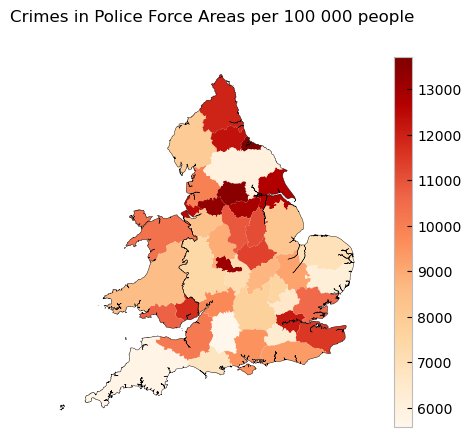

* The following bar chart shows which types of crimes were most common: 

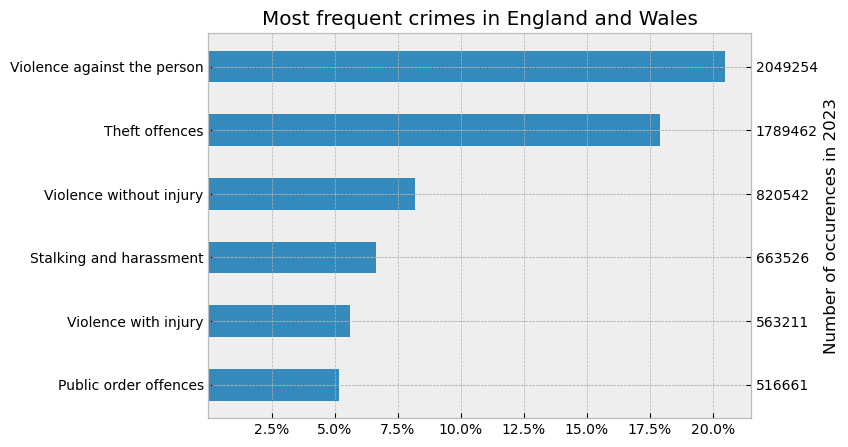

In [122]:
display(md(f"* In England and Wales, the police force area with the most crimes per population is {Most_Dangerous_PFA}."))
display(md(f"* On the other hand, the police force area with the least amount of crime per population is {Least_Dangerous_PFA}."))
display(md(f"* At the level of regions, the highest crime per population ratio is in {Most_Dangerous_Region}, and the lowest is {Least_Dangerous_Region}."))
display(md("* This data can be visualised on a map as follows: "))
display(fig1)
display(md("* The following bar chart shows which types of crimes were most common: "))
display(fig2)

# Immigration in England and Wales: Processing the data

In [124]:
# dividing the immigration data into internal and international, and calculating the percentage population change for each period
immigration_international = immigration.loc[:,(slice(None),slice(None),'Area_code')].copy() #getting just the area codes and the indices
immigration_international.columns = ['Area_code'] #re-indexing the columns to drop the multiindex
immigration_internal = immigration_international.copy()
for x in periods: #periods = the periods available in immigration data
    immigration_international[x] = ((immigration[(x,'international','inflow')] - immigration[(x,'international','outflow')]) * 100 ) / immigration[(x,'population_estimate','total')] #for each period, assigning a percentage change in inflow of immigrants
    immigration_internal[x] = ((immigration[(x,'internal','inflow')] - immigration[(x,'internal','outflow')]) * 100 ) / immigration[(x,'population_estimate','total')]
# this data is ready for plotting, and will be further prepared for analysis later

In [126]:
# plotting per region immigration:


fig3, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
ax1.plot(immigration_international.loc[Regions,periods].T.to_numpy())
ax1.set_title('International migration')
ax1.set_ylabel('Per population percentage change')
xlabels = [''] * len(periods)
xlabels[0] = '2010'
xlabels[4] = '2015'
xlabels[9] = '2020'
ax1.set_xticks(range(len(periods)))
ax1.set_xticklabels(xlabels)
ax2.plot(immigration_internal.loc[Regions,periods].T.to_numpy())
ax2.set_title('Internal migration')
ax2.set_xticks(range(len(periods)))
ax2.set_xticklabels(xlabels)
fig3.legend(Regions)
plt.close(fig3)



# # uncomment if you want to display net international migration in the UK visualised on a map
# gdf_immigration = gdf_aggregated.merge(immigration_international, left_on = 'rgn_code', right_on = 'Area_code')
# gdf_immigration.set_index(gdf_aggregated.index, inplace=True)
# gdf_immigration.plot(column = 'Mid-2019 to Mid-2020')
# plt.title("Net international migration in the UK")

# Immigration in England and Wales: overview

* ONS differentiates internation from internal immigration - international migration is the movement of people across countries, while internal migration is within.

* The following two plots show the region-wise net migration with proportion to the population of that region between the years 2010 and 2020: 

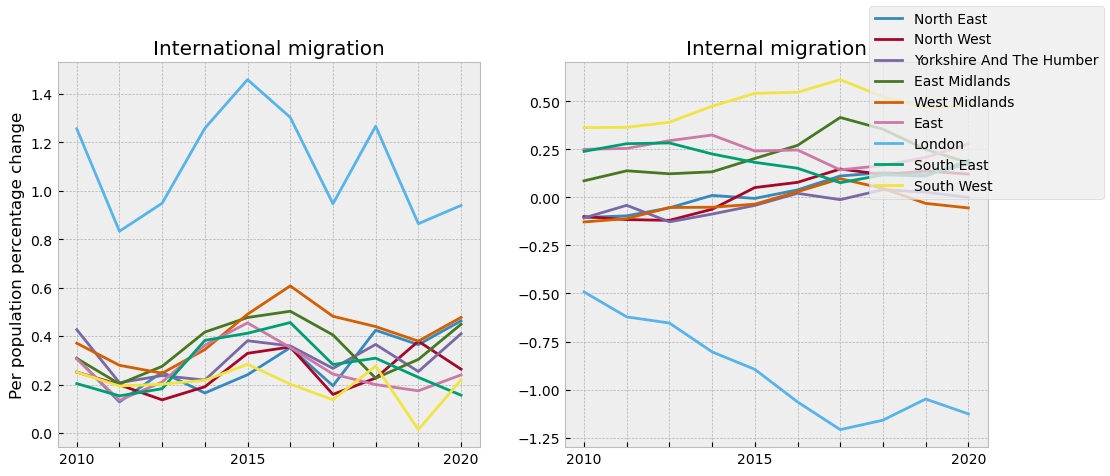

In [128]:
display(md("* ONS differentiates internation from internal immigration - international migration is the movement of people across countries, while internal migration is within."))
display(md("* The following two plots show the region-wise net migration with proportion to the population of that region between the years 2010 and 2020: "))
display(fig3)

# Immigration and crime: the analysis

In [130]:
## the analysis

# preparing data for analysis - wide to long transformation and merging with the crime data
immigration_international_long = immigration_international.reset_index().drop(columns = [
    'Mid-2010 to Mid-2011',
    'Mid-2011 to Mid-2012',
    'Mid-2012 to Mid-2013', #getting rid of the years I don't have crimes data for
    'Mid-2013 to Mid-2014']).rename(columns = {
    'Mid-2014 to Mid-2015':'2015',
    'Mid-2015 to Mid-2016':'2016',
    'Mid-2016 to Mid-2017':'2017',
    'Mid-2017 to Mid-2018':'2018',
    'Mid-2018 to Mid-2019':'2019',
    'Mid-2019 to Mid-2020':'2020', # making the immigration data match the crimes data
    1:'Area_name' # was index, renaming to Area name
    }).melt(id_vars = ['Area_name','Area_code'], var_name = 'Year', value_name = 'immigration_international') #pivoting to a long form

immigration_internal_long = immigration_internal.drop(columns = [
    'Mid-2010 to Mid-2011',
    'Mid-2011 to Mid-2012',
    'Mid-2012 to Mid-2013', #getting rid of the years I don't have crimes data for
    'Mid-2013 to Mid-2014']).rename(columns = {
    'Mid-2014 to Mid-2015':'2015',
    'Mid-2015 to Mid-2016':'2016',
    'Mid-2016 to Mid-2017':'2017',
    'Mid-2017 to Mid-2018':'2018',
    'Mid-2018 to Mid-2019':'2019',
    'Mid-2019 to Mid-2020':'2020', # making the immigration data match the crimes data
    }).melt(id_vars = ['Area_code'], var_name = 'Year', value_name = 'immigration_internal') #pivoting to a long form

crimes_long = crimes.melt(id_vars = 'Area Codes', var_name = 'Year', value_name = 'crimes') #pivoting the crimes data to long form

data_long = immigration_international_long.merge(crimes_long, left_on = ['Area_code','Year'], right_on = ['Area Codes','Year']) # merging the crimes and immigrationdatasets


data_long = data_long.merge(immigration_internal_long, on = ['Year','Area_code'])

data_long = data_long[~data_long['Area_name'].isin(['England','Wales'])] #getting rid of England and Wales datapoints to avoid pseudoreplication

data_long['Year'] = data_long['Year'].astype('category') #for good practice converting the data to appropriate data types
data_long['crimes'] = data_long['crimes'].astype(float)

model1 = smf.mixedlm('crimes ~ immigration_international + immigration_internal', data_long, groups = data_long['Area_name'], re_formula = '~immigration_international + immigration_internal', vc_formula = {'Year':'0 + C(Year)'}).fit(method='nm', maxiter=500)
# statsmodel package does not support random sloped for both random effects, i.e., the region and the year. Only one of them could be chosen
# Region was given preference in this case, because it is more likely in principle that the direction of effect will change across region than that it will change between years



# print(model1.summary()) # uncomment for analysis summary

In [132]:
def reg_line(x, y, ax='plt'): #function to plot a regression line for each region separately
    slope, intercept, r, p, std_err = stats.linregress(x.values, y.values) #extracting the necessary information by calculating a simple linear regression
    pred_y = [intercept + slope * raw_x for raw_x in x.values] # getting the predicted y values for each x value
    ax.plot(x.values, pred_y, linewidth=0.5) # plotting the predicted y values against the x values


model_intercept = model1.params['Intercept'] # extracting the overall intercept of the model
slope_international = model1.params['immigration_international'] # extracting the slope for international immigration
slope_internal = model1.params['immigration_internal'] # extracting the sloep for internal immigration

data_long['pred_imm_international'] = model_intercept + slope_international * data_long['immigration_international'] # predicted crime rates for international immigration
data_long['pred_imm_internal'] = model_intercept + slope_internal * data_long['immigration_internal'] # predicted crime rates for internal immigration



# plotting the results with london
fig4, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 12), sharey = True) #standardising the y axis
for x in Regions:
    ax1.scatter(data_long[data_long['Area_name'] == x]['immigration_international'], data_long[data_long['Area_name'] == x]['crimes'], label = x) #plotting scatter plot for each region separately
    reg_line(data_long[data_long['Area_name'] == x]['immigration_international'], data_long[data_long['Area_name'] == x]['crimes'], ax = ax1) # plotting the regression line for each region separately
ax1.set_xlabel('International Migration [Percentage Change]')
ax1.set_ylabel('Crime Rates')
ax1.set_title('Link between international migration and crime rates')

data_long.sort_values(by = 'immigration_international', inplace=True) # sorting the data for the purposes of plotting the overall regression line
ax1.plot(data_long['immigration_international'], data_long['pred_imm_international'], 'r--', linewidth = 2, alpha = 0.8) # plotting the overall predicted crime rates for international immigration data

ax1.text(1.2, 400000, f'z = {model1.tvalues["immigration_international"]:.2f}') 

for x in Regions:
    ax2.scatter(data_long[data_long['Area_name'] == x]['immigration_internal'], data_long[data_long['Area_name'] == x]['crimes'], label = x) #plotting the scatter plot for each region (done separately for each region so that they are colorcoded differently)
    reg_line(data_long[data_long['Area_name'] == x]['immigration_internal'], data_long[data_long['Area_name'] == x]['crimes'], ax = ax2) #plotting the regression line for each region
ax2.set_xlabel('Internal Migration [Percentage Change]')
ax2.set_ylabel('Crime Rates')
ax2.set_title('Link between internal migration and crime rates')

data_long.sort_values(by = 'immigration_internal', inplace=True) # sorting the data based on immigration internal for the purposes of plotting the regression line
ax2.plot(data_long['immigration_internal'], data_long['pred_imm_internal'], 'r--', linewidth = 2, alpha = 0.8) # plotting the regression line for the overall effects of internal immigration on crime

ax2.text(-1.00, 500000, f'z = {model1.tvalues["immigration_internal"]:.2f}') # showing the z statistic for the fixed effect of immigration internal

fig4.legend(title = 'Regions', handles = ax1.get_legend_handles_labels()[0], labels = Regions, bbox_to_anchor=(0.5, 0.5), loc='center', ncols=len(Regions))

plt.tight_layout(h_pad = 6)
plt.close(fig4)

In [ ]:
## this piece of code can be used to display data without London, as London seems to be somewhat on the extreme of both immigration and crime

# data_londonless = data_long[~data_long['Area_name'].isin(['London'])]
# Regions_londonless = [x for x in Regions if x != 'London']

# fig5, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
# for x in Regions_londonless:
#     ax1.scatter(data_londonless[data_londonless['Area_name'] == x]['immigration_international'], data_londonless[data_londonless['Area_name'] == x]['crimes'], label = x)
#     reg_line(data_londonless[data_londonless['Area_name'] == x]['immigration_international'], data_londonless[data_londonless['Area_name'] == x]['crimes'], ax = ax1)
# ax1.set_xlabel('International Immigration')
# ax1.set_ylabel('Crime Rates')
# ax1.legend(title = 'Regions', bbox_to_anchor=(1.05, 1), loc='upper left')
# for x in Regions_londonless:
#     ax2.scatter(data_londonless[data_londonless['Area_name'] == x]['immigration_internal'], data_londonless[data_londonless['Area_name'] == x]['crimes'], label = x)
#     reg_line(data_londonless[data_londonless['Area_name'] == x]['immigration_internal'], data_londonless[data_londonless['Area_name'] == x]['crimes'], ax = ax2)
# ax2.set_xlabel('Internal Immigration')
# ax2.set_ylabel('Crime Rates')
# plt.tight_layout()
# display(fig5)

# Immigration and crime: results

* Mixed Effects model was performed to analyse the relationship between migration and crime.

* While migration (international and internal) were treated as fixed effects, random effects of region and year of data collection were also added to the model as random effects to account for their effects on the overall trend.

* The following 2 plots shows the results of the analysis: 

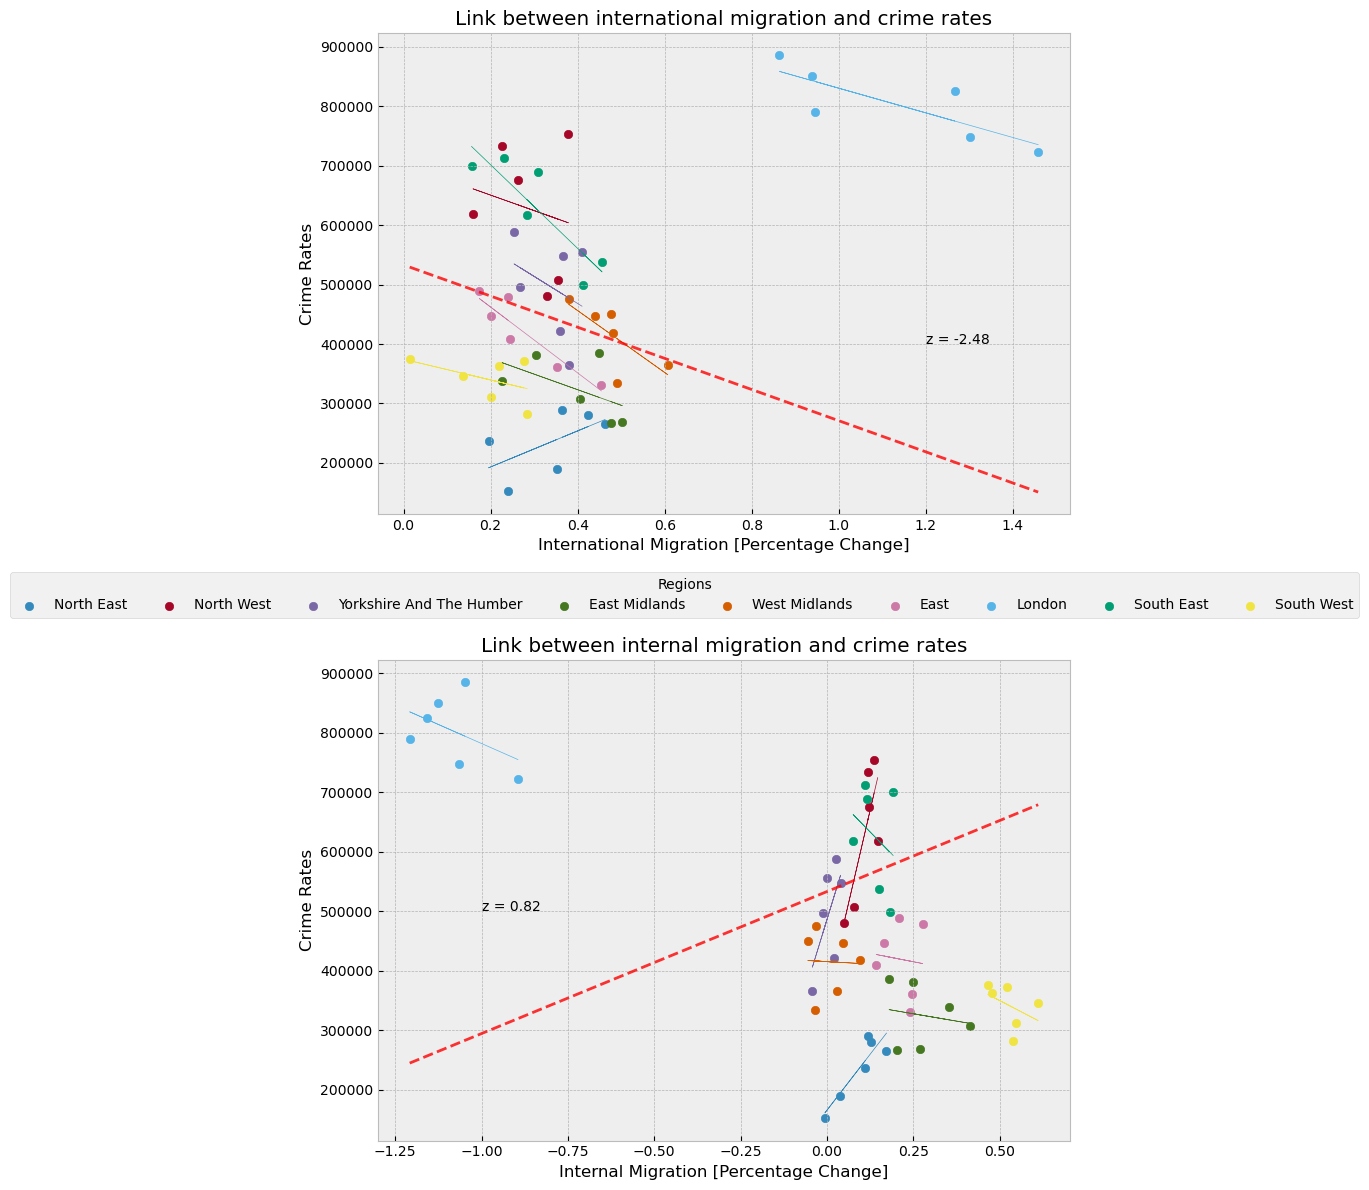

* While the internal migration was not a significant predictor of crime (p-value = 0.412, international migration was (with p-value of 0.013).

* These results show a negative relationship between immigration and crime. In other words, with increased international immigration per population in the region, crime decreases proportionally.

* It should be noted however, that crime and migration data do not overlap perfectly (and intentionally so). While the migration data has been collected December to December, the crime data is from June to June each year. In other words, the link observed is between net migration and crime rate change with 6 months of delay, as we would expect the effect of immigration on crime to not be immediate.

In [134]:
display(md("* Mixed Effects model was performed to analyse the relationship between migration and crime."))
display(md("* While migration (international and internal) were treated as fixed effects, random effects of region and year of data collection were also added to the model as random effects to account for their effects on the overall trend."))
display(md("* The following 2 plots shows the results of the analysis: "))
display(fig4)
display(md(f"* While the internal migration was not a significant predictor of crime (p-value = {model1.pvalues['immigration_internal']:.3f}, international migration was (with p-value of {model1.pvalues['immigration_international']:.3f})."))
display(md("* These results show a negative relationship between immigration and crime. In other words, with increased international immigration per population in the region, crime decreases proportionally."))
display(md("* It should be noted however, that crime and migration data do not overlap perfectly (and intentionally so). While the migration data has been collected December to December, the crime data is from June to June each year. In other words, the link observed is between net migration and crime rate change with 6 months of delay, as we would expect the effect of immigration on crime to not be immediate."))